<a href="https://colab.research.google.com/github/somuvlsi01/stocks-alpaca/blob/main/google_colab_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: get google secret key ALPACA_KEY

from google.colab import userdata
key = userdata.get('ALPACA_KEY')
secret_key = userdata.get('ALPACA_SECRET_KEY')
end_point = userdata.get('ALPACA_END_POINT')


In [ ]:
key, secret_key, end_point

('PK786IVLJ8B52VQ0XAHA',
 'XnaBJHNgl9ETaNNftKQkwVR70h1Kv1NckmlSkejD',
 'https://paper-api.alpaca.markets/v2')

In [ ]:
# prompt: install alpaca

!pip install alpaca-py
!pip install alpaca-trade-api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.1 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=bf2a7280054e1d003ff9ee1d263e8fac306658783f5780a37b594166dd3a8fe2
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.1
    Uninstalling msgpack-1.1.1:
      Successfully uninstalled msgpack-1.1.1
  Attempting uninstall

In [ ]:
## import libs

# Please change the following to your own PAPER api key and secret
# You can get them from https://alpaca.markets/
# Source code: https://github.com/alpacahq/alpaca-py/blob/master/examples/options-trading-basic.ipynb

# from api_keys import key, secret_key, end_point
# from api_keys import end_point, key, secret_key

# from live_api_keys import key, secret_key, end_point

api_key = key
secret_key = secret_key
output_data_path = "/Users/somu/Library/CloudStorage/GoogleDrive-a.somasundaran@gmail.com/My Drive/Somu/personal/penny/Stocks/Scripts/Alpaca/Data/"
# "/Users/somu/Library/CloudStorage/GoogleDrive-a.somasundaran@gmail.com/Other computers/My MacBook Pro/personal/penny/Stocks/Scripts/Alpaca/Data/"
#### We use paper environment for this example ####
paper = True  # Please do not modify this. This example is for paper trading only.
# paper = False # Please do not modify this. This example is for paper trading only.
####

# Below are the variables for development this documents
# Please do not change these variables

trade_api_url = None  # paper
# trade_api_url = "https://api.alpaca.markets" # live
trade_api_wss = None
data_api_url = None
option_stream_data_wss = None

# install alpaca-py
#! python3 -m pip install alpaca-py

import json
from datetime import datetime, timedelta

from math import ceil, floor
from zoneinfo import ZoneInfo

import alpaca
import pandas as pd
from alpaca.common.exceptions import APIError
from alpaca.data.historical.option import OptionHistoricalDataClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.live.option import OptionDataStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    OptionBarsRequest,
    OptionChainRequest,
    OptionLatestQuoteRequest,
    OptionLatestTradeRequest,
    OptionSnapshotRequest,
    OptionTradesRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import (
    AssetExchange,
    AssetStatus,
    ExerciseStyle,
    OrderClass,
    OrderSide,
    OrderType,
    QueryOrderStatus,
    TimeInForce,
)
from alpaca.trading.requests import (
    ClosePositionRequest,
    ContractType,
    GetAssetsRequest,
    GetOptionContractsRequest,
    GetOrdersRequest,
    LimitOrderRequest,
    MarketOrderRequest,
    StopLimitOrderRequest,
    StopLossRequest,
    StopOrderRequest,
    TakeProfitRequest,
    TrailingStopOrderRequest,
)
from alpaca.trading.stream import TradingStream
import numpy as np


In [ ]:
underlying_symbols = [
    # "QQQ"
    # "NVDA"
    "SPY"
]

In [ ]:


# import numpy as np

# to run async code in jupyter notebook
# import nest_asyncio
# nest_asyncio.apply()

# setup clients
trade_client = TradingClient(
    api_key=api_key, secret_key=secret_key, paper=paper, url_override=trade_api_url
)

print("trade client created")
print(trade_client)

# check trading account
# There are trhee new columns in the account object:
# - options_buying_power
# - options_approved_level
# - options_trading_level
acct = trade_client.get_account()
print(acct)

# check account configuration
# - we have new field `max_options_trading_level`
acct_config = trade_client.get_account_configurations()
print(acct_config)


# get list of assets which are options enabled
# - we can filter assets by `options_enabled` attribute
# - asset object has `options_enabled` attribute if it is options enabled
req = GetAssetsRequest(attributes="options_enabled")
assets = trade_client.get_all_assets(req)
print(assets[:2])


# get list of options contracts for the given underlying symbol (e.g. SPY,AAPL)
# - get_option_contracts() is a new method to get list of options contracts
# - in this example, we get 2 options contracts for SPY,AAPL
# - you can continue to fetch options contracts by specifying page_token from next_page_token of response
req = GetOptionContractsRequest(
    underlying_symbols=underlying_symbols,  # specify underlying symbols
    status=AssetStatus.ACTIVE,  # specify asset status: active (default)
    expiration_date="2024-08-23",  # specify expiration date (specified date + 1 day range)
    expiration_date_gte=None,  # we can pass date object
    expiration_date_lte=None,  # or string (YYYY-MM-DD)
    root_symbol=None,  # specify root symbol
    type=ContractType.CALL,  # specify option type (ContractType.CALL or ContractType.PUT)
    style=None,  # specify option style (ContractStyle.AMERICAN or ContractStyle.EUROPEAN)
    strike_price_gte="550",  # specify strike price range
    strike_price_lte="570",  # specify strike price range
    limit=2,  # specify limit
    page_token=None,  # specify page token
)
res = trade_client.get_option_contracts(req)
print(res)

# setup stock historical data client
stock_historical_data_client = StockHistoricalDataClient(
    api_key, secret_key, url_override=data_api_url
)
# get historical bars by symbol
# ref. https://docs.alpaca.markets/reference/stockbars-1
now = datetime.now(ZoneInfo("America/New_York"))
start = datetime(2024, 1, 1, 16, 30, 0, 0)
# end=datetime(2024, 8, 26, 16, 30, 0, 0)
end = day1 = now + timedelta(hours=-1)
req = StockBarsRequest(
    symbol_or_symbols=underlying_symbols,
    timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Day),  # specify timeframe
    start=start,  # specify start datetime, default=the beginning of the current day.
    # start = now,                          # specify start datetime, default=the beginning of the current day.
    # start = now - timedelta(days = 5),                          # specify start datetime, default=the beginning of the current day.
    end=end,  # specify end datetime, default=now
    # limit = 10,                                               # specify limit
)
df_stocks = stock_historical_data_client.get_stock_bars(req).df
# df_stocks["date_id"] = df_stocks["timestamp"].dt.date()
print("df_stocks count")
# print(df_stocks)
print(len(df_stocks))


# setup option historical data client
option_historical_data_client = OptionHistoricalDataClient(
    api_key, secret_key, url_override=data_api_url
)
now = datetime.now(tz=ZoneInfo("America/New_York"))
day1 = now + timedelta(days=1)
day60 = now + timedelta(days=60)

# get options historical bars by symbol
# req = OptionBarsRequest(
#     symbol_or_symbols = "SPY240822C00551000" ,
#     timeframe = TimeFrame(amount = 1, unit = TimeFrameUnit.Hour),   # specify timeframe
#     start = now - timedelta(days = 5),                              # specify start datetime, default=the beginning of the current day.
#     # end_date=None,                                                # specify end datetime, default=now
#     limit = 2,                                                      # specify limit
# )
i = 0

for index, row in df_stocks.iterrows():
    tmp_stock_symbol = index[0]
    tmp_stock_date = index[1]
    tmp_stock_yy = str(tmp_stock_date.year)[2:]
    tmp_stock_mm = str(tmp_stock_date.month).zfill(2)
    tmp_stock_dd = str(tmp_stock_date.day).zfill(2)
    # set target price below

    # tmp_stock_price_ceil = str(ceil(row["open"]) + 1).zfill(5)
    # tmp_stock_price_ceil = str(ceil(row["open"])).zfill(5)
    tmp_stock_price_ceil = str(floor(row["open"])).zfill(5)

    tmp_option_symbol = (
        tmp_stock_symbol
        + tmp_stock_yy
        + tmp_stock_mm
        + tmp_stock_dd
        + "C"  # call
        + tmp_stock_price_ceil
        + "000"  # empty leading zeros
    )
    # print(
    #     tmp_stock_date,
    #     tmp_stock_date,
    #     tmp_stock_yy,
    #     tmp_option_symbol
    # )

    # get options historical bars by symbol

    req = OptionBarsRequest(
        symbol_or_symbols=tmp_option_symbol,
        timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Hour),  # specify timeframe
        start=tmp_stock_date,  # specify start datetime, default=the beginning of the current day.
        # start = now - timedelta(days = 5),                              # specify start datetime, default=the beginning of the current day.
        # end_date=None,                                                # specify end datetime, default=now
        # limit = 2,                                                      # specify limit
    )
    tmp_df = option_historical_data_client.get_option_bars(req).df
    if tmp_df.empty:
        continue
    tmp_df["stock_open"] = row["open"]
    tmp_df["stock_high"] = row["high"]
    tmp_df["stock_low"] = row["low"]
    tmp_df["stock_close"] = row["close"]
    tmp_df["stock_date"] = tmp_stock_date
    # df1.sort_index(inplace=True)
    # print("tmp_df")
    # print(tmp_df)
    # print(tmp_df["high"])

    # tmp_df.loc[tmp_df["high"] >= 0.25, "is_high_gt_0_25"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 0.5, "is_high_gt_0_5"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 0.75, "is_high_gt_0_75"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 0.8, "is_high_gt_0_8"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 0.9, "is_high_gt_0_9"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.0, "is_high_gt_1"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.1, "is_high_gt_1_1"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.2, "is_high_gt_1_2"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.3, "is_high_gt_1_3"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.4, "is_high_gt_1_4"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.5, "is_high_gt_1_5"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 1.6, "is_high_gt_1_6"] = 1.0
    # tmp_df.loc[tmp_df["high"] >= 2.0, "is_high_gt_2"] = 1.0

    tmp_df["is_high_gt_0_25"] = np.where(tmp_df["high"] >= 0.25, 1.0, 0.0)
    tmp_df["is_high_gt_0_5"] = np.where(tmp_df["high"] >= 0.5, 1.0, 0.0)
    tmp_df["is_high_gt_0_75"] = np.where(tmp_df["high"] >= 0.75, 1.0, 0.0)
    tmp_df["is_high_gt_0_8"] = np.where(tmp_df["high"] >= 0.8, 1.0, 0.0)
    tmp_df["is_high_gt_0_9"] = np.where(tmp_df["high"] >= 0.9, 1.0, 0.0)
    tmp_df["is_high_gt_1"] = np.where(tmp_df["high"] >= 1.0, 1.0, 0.0)
    tmp_df["is_high_gt_1_1"] = np.where(tmp_df["high"] >= 1.1, 1.0, 0.0)
    tmp_df["is_high_gt_1_2"] = np.where(tmp_df["high"] >= 1.2, 1.0, 0.0)
    tmp_df["is_high_gt_1_3"] = np.where(tmp_df["high"] >= 1.3, 1.0, 0.0)
    tmp_df["is_high_gt_1_4"] = np.where(tmp_df["high"] >= 1.4, 1.0, 0.0)
    tmp_df["is_high_gt_1_5"] = np.where(tmp_df["high"] >= 1.5, 1.0, 0.0)
    tmp_df["is_high_gt_1_6"] = np.where(tmp_df["high"] >= 1.6, 1.0, 0.0)
    tmp_df["is_high_gt_2"] = np.where(tmp_df["high"] >= 2.0, 1.0, 0.0)


    tmp_agg_df = tmp_df.groupby(["stock_date"])[
        [
            "is_high_gt_0_25",
            "is_high_gt_0_5",
            "is_high_gt_0_75",
            "is_high_gt_0_8",
            "is_high_gt_0_9",
            "is_high_gt_1",
            "is_high_gt_1_1",
            "is_high_gt_1_2",
            "is_high_gt_1_3",
            "is_high_gt_1_4",
            "is_high_gt_1_5",
            "is_high_gt_1_6",
            "is_high_gt_2",
        ]
    ].max()
    # print("agg df")
    # print(agg_df)

    if i == 0:
        df1 = tmp_df
        agg_df = tmp_agg_df
    else:
        df1 = pd.concat([df1, tmp_df])
        agg_df = pd.concat([agg_df, tmp_agg_df])
    i = i + 1

# filtered_df = df1.query(
#     """
#     high >= 1.0
#     """
#     # and stock_open > stock_close
# )
# print("filtered_df uique dates")
# print(
#     len(filtered_df["stock_date"].unique())
# )
# print(filtered_df)

# Get column names
# column_names = df_stocks.columns.tolist()
# print("column_names")
# print(column_names)


# df1 = option_historical_data_client.get_option_bars(req).df
# print(df1)


# get historical trades by symbol
# req = StockTradesRequest(
#     symbol_or_symbols = underlying_symbols,
#     start = start,                          # specify start datetime, default=the beginning of the current day.
#     # start = now ,
#     # now - timedelta(days = 5),                          # specify start datetime, default=the beginning of the current day.
#     end=end,                                             # specify end datetime, default=now
#     # limit = 10,                                                # specify limit
# )
# df_quote = stock_historical_data_client.get_stock_trades(req).df
# print(df_quote)


# join two dfs

# Create two example DataFrames
# df1 = pd.DataFrame({
#    'A': ['A0', 'A1', 'A2'],
#    'B': ['B0', 'B1', 'B2']
# }, index=['K0', 'K1', 'K2'])
# df2 = pd.DataFrame({
#    'C': ['C0', 'C2', 'C3'],
#    'D': ['D0', 'D2', 'D3']
# }, index=['K0', 'K2', 'K3'])
# # Perform a join operation
# result = df1.join(df2)
# agg_df["stock_yyyymm"] = str(agg_df["stock_date"])[0:7]
print("agg_df")
len_agg_df = len(agg_df)
print(len_agg_df)
# fil_name = output_data_path + "agg_df" + now.strftime("%Y%m%d%H%M%S") + ".csv"
# agg_df.to_csv(fil_name)


trade client created
id=UUID('0a629183-9bc2-4c0e-a831-4e80c952d01a') account_number='PA2YRR27SRSM' status=<AccountStatus.ACTIVE: 'ACTIVE'> crypto_status=<AccountStatus.ACTIVE: 'ACTIVE'> currency='USD' buying_power='200000' regt_buying_power='200000' daytrading_buying_power='0' non_marginable_buying_power='98000' cash='100000' accrued_fees='0' pending_transfer_out=None pending_transfer_in=None portfolio_value='100000' pattern_day_trader=True trading_blocked=False transfers_blocked=False account_blocked=False created_at=datetime.datetime(2020, 9, 12, 3, 12, 42, 93088, tzinfo=TzInfo(UTC)) trade_suspended_by_user=False multiplier='2' shorting_enabled=True equity='100000' last_equity='100000' long_market_value='0' short_market_value='0' initial_margin='0' maintenance_margin='0' last_maintenance_margin='0' sma='0' daytrade_count=0 options_buying_power=None options_approved_level=None options_trading_level=None
dtbp_check=<DTBPCheck.ENTRY: 'entry'> fractional_trading=True max_margin_multiplie

In [ ]:
# prompt: create new column stock_yyyymm in agg_df by taking the first 7 characters of stock_date

agg_df["stock_yyyymm"] = agg_df.index.get_level_values('stock_date').astype(str).str[:7]

In [ ]:
# # prompt: visualize the dataframe agg_df stock_date as x-axis and SUM(is_high_gt_2)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.bar(agg_df["stock_yyyymm"], agg_df['is_high_gt_2'])  # Convert index to string for plotting
# plt.xlabel('stock_month')
# plt.ylabel('AVG(is_high_gt_2)')
# plt.title('AVG(is_high_gt_2) over time')
# plt.xticks(rotation=45) # Rotate x-axis labels for better readability
# plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.show()

In [ ]:
# # prompt: display data points labels in the y axis

# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.bar(agg_df["stock_yyyymm"], agg_df['is_high_gt_2'].fillna(0))  # Convert index to string for plotting
# plt.xlabel('stock_month')
# plt.ylabel('is_high_gt_2') # Changed label to reflect the data being plotted
# plt.title('Count of is_high_gt_2 over time') # Changed title to reflect the data being plotted
# plt.xticks(rotation=45) # Rotate x-axis labels for better readability
# plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.show()


In [ ]:
# prompt: create new dataframe that is keeping stock_yyyymm from as the key column and agg_df and gets the AVG(is_high_gt_*) other columns

import matplotlib.pyplot as plt
# Reset index to make 'stock_yyyymm' a column
agg_df_reset = agg_df.reset_index()

# Group by 'stock_yyyymm' and calculate the mean of the specified columns
monthly_avg_df = agg_df_reset.groupby('stock_yyyymm')[
    [
        "is_high_gt_0_25",
        "is_high_gt_0_5",
        "is_high_gt_0_75",
        "is_high_gt_0_8",
        "is_high_gt_0_9",
        "is_high_gt_1",
        "is_high_gt_1_1",
        "is_high_gt_1_2",
        "is_high_gt_1_3",
        "is_high_gt_1_4",
        "is_high_gt_1_5",
        "is_high_gt_1_6",
        "is_high_gt_2",
    ]
].mean().round(3).reset_index()



In [ ]:

# print("\nMonthly Average DataFrame:")
# print(monthly_avg_df)

# # Plotting the monthly average of is_high_gt_2
# plt.figure(figsize=(12, 6))
# plt.bar(monthly_avg_df["stock_yyyymm"], monthly_avg_df['is_high_gt_2'])
# plt.xlabel('stock_month')
# plt.ylabel('AVG(is_high_gt_2)', labelpad = 1.0 )
# plt.title('Monthly Average of is_high_gt_2')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # # Plotting the monthly average of is_high_gt_0_25
# # plt.figure(figsize=(12, 6))
# # plt.bar(monthly_avg_df["stock_yyyymm"], monthly_avg_df['is_high_gt_0_25'].fillna(0))
# # plt.xlabel('stock_month')
# # plt.ylabel('AVG(is_high_gt_0_25)')
# # plt.title('Monthly Average of is_high_gt_0_25')
# # plt.xticks(rotation=45)
# # plt.tight_layout()
# # plt.show()

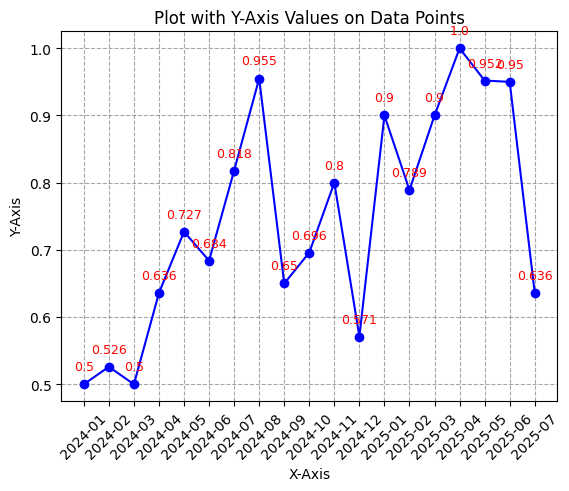

In [ ]:
plt.plot(monthly_avg_df["stock_yyyymm"], monthly_avg_df['is_high_gt_2'], marker='o', linestyle='-', color='blue') # Plot the data points and connect them with a line

# Add the y-value labels to each data point
for i, (x, y) in enumerate(zip(monthly_avg_df["stock_yyyymm"], monthly_avg_df['is_high_gt_2'])):
    plt.annotate(
        f'{y}',  # Text to display, formatted as a string (f-string for convenience)
        (x, y),  # The point (x, y) to annotate
        textcoords="offset points",  # Position the text relative to the point
        xytext=(0, 10),  # Offset the text by 10 points vertically from the point
        ha='center',  # Horizontal alignment of the text (centered above the point)
        fontsize=9, # Optional: Adjust the font size of the labels
        color='red' # Optional: Set the color of the labels
    )

# Customize the plot (optional)
plt.title("Plot with Y-Axis Values on Data Points")
plt.xlabel("X-Axis")
plt.xticks(rotation=45)
plt.ylabel("Y-Axis")
plt.grid(True, linestyle="--", color='grey', alpha=0.7) # Add a grid
plt.show()

In [ ]:
## build agg

agg_sum = agg_df[
    [
        "is_high_gt_0_25",
        "is_high_gt_0_5",
        "is_high_gt_0_75",
        "is_high_gt_0_8",
        "is_high_gt_0_9",
        "is_high_gt_1",
        "is_high_gt_1_1",
        "is_high_gt_1_2",
        "is_high_gt_1_3",
        "is_high_gt_1_4",
        "is_high_gt_1_5",
        "is_high_gt_1_6",
        "is_high_gt_2",
    ]
].sum()
agg_sum["pct_is_high_gt_0_25"] = (100.0 * agg_sum["is_high_gt_0_25"]) / len_agg_df
agg_sum["pct_is_high_gt_0_5"] = (100.0 * agg_sum["is_high_gt_0_5"]) / len_agg_df
agg_sum["pct_is_high_gt_0_75"] = (100.0 * agg_sum["is_high_gt_0_75"]) / len_agg_df
agg_sum["pct_is_high_gt_0_8"] = (100.0 * agg_sum["is_high_gt_0_8"]) / len_agg_df
agg_sum["pct_is_high_gt_0_9"] = (100.0 * agg_sum["is_high_gt_0_9"]) / len_agg_df
agg_sum["pct_is_high_gt_1"] = (100.0 * agg_sum["is_high_gt_1"]) / len_agg_df
agg_sum["pct_is_high_gt_1_1"] = (100.0 * agg_sum["is_high_gt_1_1"]) / len_agg_df
agg_sum["pct_is_high_gt_1_2"] = (100.0 * agg_sum["is_high_gt_1_2"]) / len_agg_df
agg_sum["pct_is_high_gt_1_3"] = (100.0 * agg_sum["is_high_gt_1_3"]) / len_agg_df
agg_sum["pct_is_high_gt_1_4"] = (100.0 * agg_sum["is_high_gt_1_4"]) / len_agg_df
agg_sum["pct_is_high_gt_1_5"] = (100.0 * agg_sum["is_high_gt_1_5"]) / len_agg_df
agg_sum["pct_is_high_gt_1_6"] = (100.0 * agg_sum["is_high_gt_1_6"]) / len_agg_df
agg_sum["pct_is_high_gt_2"] = (100.0 * agg_sum["is_high_gt_2"]) / len_agg_df

print(agg_sum)

# print(agg_df)


is_high_gt_0_25        372.000000
is_high_gt_0_5         372.000000
is_high_gt_0_75        371.000000
is_high_gt_0_8         371.000000
is_high_gt_0_9         371.000000
is_high_gt_1           371.000000
is_high_gt_1_1         364.000000
is_high_gt_1_2         361.000000
is_high_gt_1_3         358.000000
is_high_gt_1_4         351.000000
is_high_gt_1_5         344.000000
is_high_gt_1_6         333.000000
is_high_gt_2           282.000000
pct_is_high_gt_0_25    100.000000
pct_is_high_gt_0_5     100.000000
pct_is_high_gt_0_75     99.731183
pct_is_high_gt_0_8      99.731183
pct_is_high_gt_0_9      99.731183
pct_is_high_gt_1        99.731183
pct_is_high_gt_1_1      97.849462
pct_is_high_gt_1_2      97.043011
pct_is_high_gt_1_3      96.236559
pct_is_high_gt_1_4      94.354839
pct_is_high_gt_1_5      92.473118
pct_is_high_gt_1_6      89.516129
pct_is_high_gt_2        75.806452
dtype: float64
